# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

## Brief introduction to the Project

For this analysis, we use 5 years of historical stock data for 6 specified stocks: 


- **AAPL**: Apple Inc.  
- **GM**: General Motors Company  
- **NFLX**: Netflix, Inc.  
- **F**: Ford Motor Company  
- **ADBE**: Adobe Inc.  
- **TSLA**: Tesla, Inc.

1. **Data Preparation and Visualization:**  
   We begin by downloading the stock data using the `yfinance` library. Next, we normalize the daily closing prices by dividing each day’s closing price by the closing price on the first day, effectively scaling all stock prices to start from 1. We then adjust these normalized prices by subtracting 1, so that all stocks start at 0 for better comparative visualization. Finally, we plot these normalized returns as a function of time for all selected stocks.

2. **Volatility Calculation:**  
   We compute daily log returns for each stock and calculate their standard deviation. To estimate yearly volatility, we scale this value by multiplying by the square root of 252, where 252 represents the average number of trading days per year.

3. **Portfolio Construction:**  
   We assign weights to each stock representing the fraction of the total principal invested.

   - **i) Minimum Volatility Portfolio:**  
     To build a low-risk portfolio, we minimize portfolio volatility based on the quarterly volatility computed previously. To encourage diversification, we impose constraints such that each stock must have a minimum allocation of 5% of the capital, and no stock can comprise more than 30% of the portfolio.

   - **ii) Equal Weight Portfolio:**  
     For higher risk, we also construct a portfolio where capital is allocated equally among all selected stocks, without optimization.


## Uploading and plotting stock data for past 5 years

In [71]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

In [72]:
tickers = ["AAPL", "GM", "NFLX", "F", "ADBE", "TSLA"]

start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end =end_date)

/tmp/ipykernel_3392700/262517088.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end =end_date)
[*********************100%***********************]  6 of 6 completed


### Normalizing the daily returns 

In [73]:
#Compute cumulative return from 'Close' prices
close = stock['Close']
#Moves stock prices to a start of 0
normalized_returns = close/close.iloc[0]-1


#Create MultiIndex columns for new data i.e. normalized returns
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

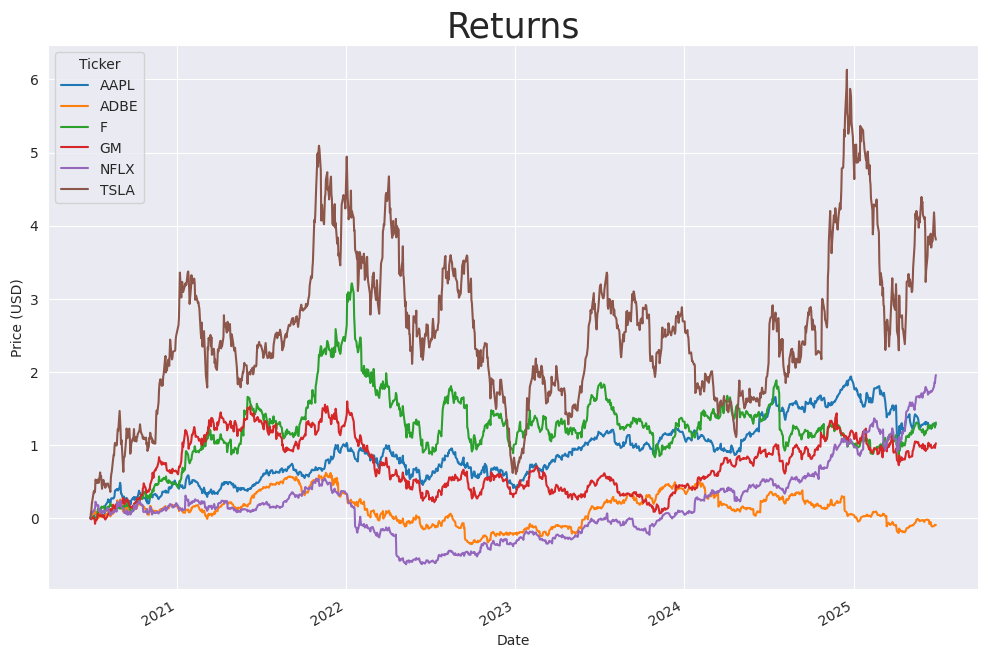

In [74]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

## Calculating  Volatility

We calculate volatility by taking log-daily returns and using the standard deviation by square root of 252 to give the yearly volatility

In [75]:
#Find daily log returns for stocks
daily_log_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_log_returns = daily_log_returns.dropna()


#Normalize the standard deviation for quartely by multiplying by sqrt(#trading days in year ~ 252)/4
yearly_volatility = {ticker: np.std(daily_log_returns[ticker])*np.sqrt(252) for ticker in tickers}


yearly_volatility

{'AAPL': 0.29734459692721427,
 'GM': 0.3774865366642569,
 'NFLX': 0.4581346160805046,
 'F': 0.4007542816424515,
 'ADBE': 0.365180717850169,
 'TSLA': 0.6405736992886208}

In [70]:
#covariance matrix for daily return distribution of stocks

covariance_matrix = 252*((daily_log_returns).cov())
covariance_matrix

Ticker,AAPL,ADBE,F,GM,NFLX,TSLA
Ticker,,,,,,
AAPL,0.088484,0.058768,0.037002,0.032724,0.056197,0.095660
ADBE,0.058768,0.133463,0.034554,0.030995,0.074091,0.090830
F,0.037002,0.034554,0.160732,0.115978,0.039653,0.077165
GM,0.032724,0.030995,0.115978,0.142610,0.040471,0.074115
NFLX,0.056197,0.074091,0.039653,0.040471,0.210055,0.104583
TSLA,0.095660,0.090830,0.077165,0.074115,0.104583,0.410662


## Building the portfolio

To construct the portfolio for the given stocks, we determine a set of weights representing the proportion of the total investment allocated to each stock.

For a profitable portfolio, the expected returns should be positive.

### For lower risk profile


To reduce risk, we optimize the portfolio by minimizing the quarterly volatility, as described in the previous section.

In addition, to promote diversification, we impose the following constraints on the allocation:  
1. A minimum investment of 5% of the capital in each stock.  
2. A maximum investment limit of 30% of the capital in any single stock.

In [77]:
# Number of assets i.e. stocks
n_assets = len(tickers)

# Define an initial guess for asset weights (we take equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}, #Sum of weights equals 1 
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.05}, #Allocate at least 5% of capital into each index in stock_symbols
              {'type': 'ineq', 'fun': lambda weights: .30-max(weights)}) #Do not allocate more than 30% of capital into each index in stock_symbol

# Objective function to minimize portfolio variance i.e. yearly volatility
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights with constraints
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Calculate normalized return
optimized_return=np.dot([np.mean(stock['Cumulative Return'][ticker]) for ticker in tickers],optimal_weights)


# Print results i.e. the optimal weights and expected returns
print('--'*40)

print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
print('--'*40)
print('--'*40)

print(f' The optimal volatility subject to the constraints: {result.fun}')
print(f' Average daily return: {optimized_return}')
print('--'*40)    

--------------------------------------------------------------------------------
Optimal Asset Weights to minimize volatility:
AAPL: Weight = 0.3000
GM: Weight = 0.2304
NFLX: Weight = 0.0956
F: Weight = 0.2432
ADBE: Weight = 0.0808
TSLA: Weight = 0.0500
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 The optimal volatility subject to the constraints: 0.2622869453719743
 Average daily return: 0.890334215242955
--------------------------------------------------------------------------------


### For higher risk profile

For this portfolio, we allocate equal weights to all the stocks.

In [78]:
n_assets = len(tickers)

# Portfolio with eqaul weights for each stock
equal_weights = np.array([1/n_assets] * n_assets)

# Calculte return for the portfolio
calculated_return = np.dot([np.mean(stock['Cumulative Return'][ticker]) for ticker in tickers], equal_weights)

# Calculate yearly volatality for the portfolio
calculated_volatility = np.sqrt(np.dot(initial_weights.T, np.dot(covariance_matrix, equal_weights)))


#print results

print('--'*40)

print("Equal Asset Weights:")
for ticker, weight in zip(tickers, equal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
print('--'*40)
print(f' Average daily return for equal is give by: {calculated_return} ')
print(f'Volatility is {calculated_volatility} ')
print('--'*40)

--------------------------------------------------------------------------------
Equal Asset Weights:
AAPL: Weight = 0.1667
GM: Weight = 0.1667
NFLX: Weight = 0.1667
F: Weight = 0.1667
ADBE: Weight = 0.1667
TSLA: Weight = 0.1667
--------------------------------------------------------------------------------
 Average daily return for equal is give by: 0.954744033508575 
Volatility is 0.2920985969007382 
--------------------------------------------------------------------------------


### Concluding remarks

The equal-weighted portfolio yields an average daily return of 0.95 with a yearly volatility of 0.29. The optimized portfolio reduces volatility to 0.26 while delivering a slightly lower average daily return of 0.89. This demonstrates that portfolio optimization can effectively lower risk with a marginal impact on returns. However, both the portfolios are profitable since average daily return>0.